In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from sklearn.model_selection import train_test_split
from scipy.io import savemat, loadmat
import pylab as plt
import numpy as np
from scipy.spatial.distance import cdist
from IPython.display import clear_output
import ipywidgets as ipw
import scipy.ndimage as ndimage
from scipy.interpolate import RegularGridInterpolator
import timeit
import sys
from scipy.ndimage import gaussian_filter
from tqdm import tqdm_notebook

In [3]:
sys.path.append('../../')

In [4]:
import src.approximation as appr
from src import ml_utils
from src.openst import OpenST as ost
from src import plot_utils

Using TensorFlow backend.


In [5]:
def data_input_layered():
    data = loadmat('../data/layered_traveltimes.mat')
    vp = loadmat('../data/layered_model.mat')['vp'].T
    time = data['time']
    sou = np.stack([np.float32(data['SX']), np.float32(data['SZ'])], axis=-1)
    rec = np.stack([np.float32(data['SX'][:,0]), np.float32(data['SX'][0,:])]).T
    return sou, rec, time, vp

def data_input_seg():
    data = loadmat('../data/seg_traveltimes.mat')
    vp = data['SpeedImage'][:,0,:]
    time = data['time']
    sou = np.stack([np.float32(data['SX']), np.float32(data['SZ'])], axis=-1)
    rec = np.stack([np.float32(data['SX'][:,0]), np.float32(data['SX'][0,:])]).T
    return sou, rec, time, vp

def init_interpolation(sou, rec, time):
    x = rec[:,0]
    y = sou[0,:,1]
    z = sou[:,0,0]
    assert len(time.shape)>2 and time.shape[0]==rec.shape[0]
    
    return RegularGridInterpolator((x, y, z), time, method='linear', bounds_error=False, fill_value=None)

def get_bytes(ns, nr, byte=8):
    print('1 float value: {0} bytes'.format(byte))
    print('For {0} sources and {1} receivers:'.format(ns, nr))
    b = float(nr) * float(ns) * float(byte)
    kb = b / 1024
    mb = kb / 1024
    gb = mb / 1024
    print('{0:.2f} bytes'.format(b))
    print('{0:.2f} Kbytes\t{1:.2f} Mbytes\t{2:.2f} Gbytes'.format(kb, mb, gb))

In [6]:
V = np.load('../../data/Marmousi_Pwave_smooth_12.5m.npy')

In [7]:
nx, nz = V.shape
GridSize = np.array((nx, nz))
GridStep = np.array([12.5, 12.5])
xmax, zmax = (GridSize[0] - 1) * GridStep[0], (GridSize[1] - 1) * GridStep[1]
x, z = np.linspace(0, xmax, nx), np.linspace(0, zmax, nz)

CoordLimLow = np.array([0, 0], dtype=np.float64)
CoordLimHigh = np.array([xmax, zmax], dtype=np.float64)
src = np.array([int(GridSize[0]) / 2 * GridStep[0], int(GridSize[1]) / 2 * GridStep[1]])

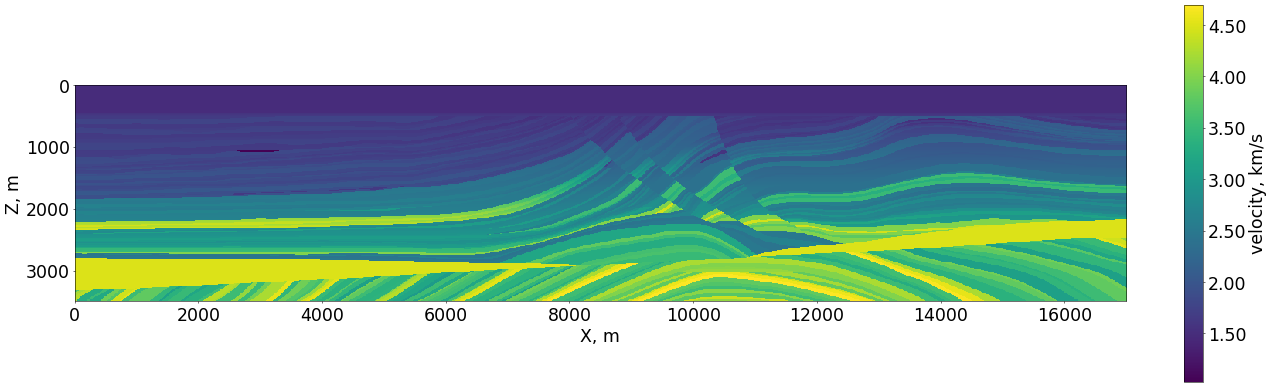

In [8]:
extent = (0, xmax, 0, zmax)
figsize = (30, 10)
colorbars = True
fontsize = 25
cbar_labels = [['velocity, km/s']]
fig, axes = plot_utils.plot_images(imgs=[[V.T / 1000.0]], cols_names=[['']],
                                   imshows=True, figsize=figsize, extent=extent, colorbars=True, cbar_labels=cbar_labels, fontsize=fontsize)
plt.show()

In [9]:
get_bytes(GridSize.prod(), GridSize[0])

1 float value: 8 bytes
For 382441 sources and 1361 receivers:
4164017608.00 bytes
4066423.45 Kbytes	3971.12 Mbytes	3.88 Gbytes


In [17]:
%%time
T = np.empty((nx, nx, nz), dtype=float)
with tqdm_notebook(total=nx, desc='FSM calculation') as p_bar:
    for i in range(nx):
        src = np.array([x[i], 0.0])
        T[i] = ost.LSM2D(V_smooth, CoordLimLow, CoordLimHigh, GridStep, src)
        p_bar.update()


Wall time: 3min 35s


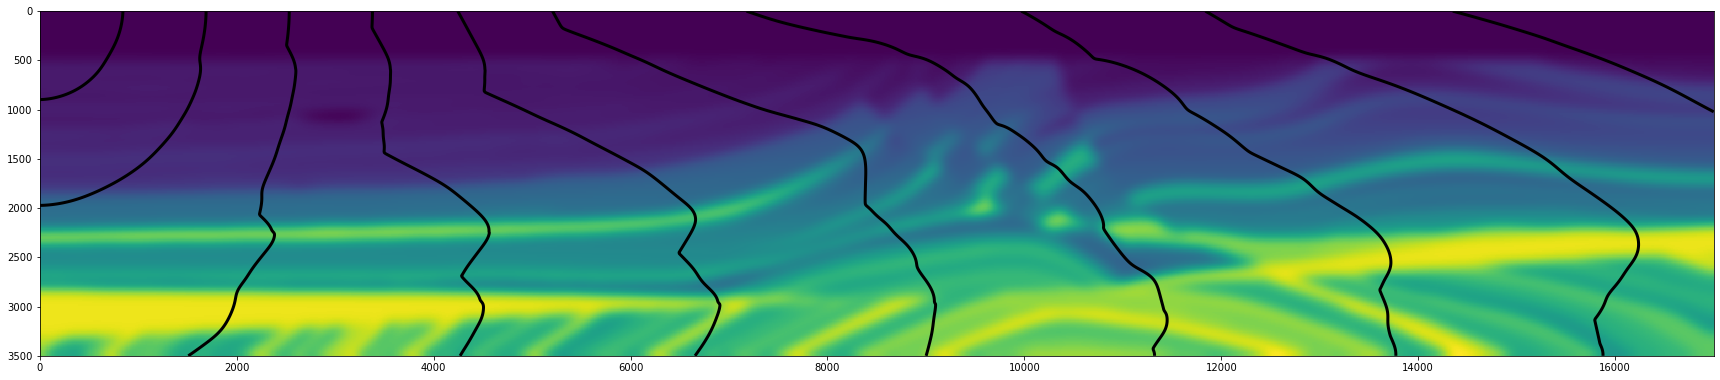

In [23]:
plt.figure(figsize=(30,15))

levels = np.linspace(0, T[0].max(), 12)
plt.imshow(V.T, extent=(0, xmax, zmax, 0))
plt.contour(T[0].T, levels=levels, colors='k', linewidths=3, extent=(0, xmax, 0, zmax))
plt.ylim([zmax, 0])
plt.axis('scaled')

plt.show()

In [20]:
T = np.load('C:/users/grubassi/data/marmousi2D/times.npy')

In [24]:
scaler_x = ml_utils.Scaler(x)
scaler_z = ml_utils.Scaler(z)
x_sc = scaler_x.scale(x)
z_sc = scaler_z.scale(z)

In [13]:
sx = [100, 80, 60, 40, 20, 12, 8, 4, 2]
sz = sx

In [14]:
%%time
batches_input, batches_output = [], []
for s1, s2 in zip(sx, sz):
    i, o = appr.Approximator.prepare_inputs(inputs=[x_sc, x_sc, z_sc], outputs=T[...,None], 
                                                flatenned=False, sparse=[1,s1,s2],)
    batches_input.append(i)
    batches_output.append(o)

Wall time: 1min 56s


In [25]:
Xr, Xs, Zs = np.meshgrid(x_sc, x_sc[::2], z_sc[::2], indexing='ij')
inputs = [Xr.ravel(), Xs.ravel(), Zs.ravel()]
names = ['input_0', 'input_1', 'input_2']
input_test = {kw:v for kw, v in zip(names, inputs)}

In [12]:
from keras import optimizers
import keras
import keras.backend as K

In [21]:
adam = optimizers.Adam(lr=1e-3, decay=1e-4, amsgrad=False)
plot_losses = ml_utils.PlotLosses()
early = keras.callbacks.EarlyStopping(monitor='mae', min_delta=1e-8, patience=4, verbose=2, 
                                        mode='auto', baseline=None, restore_best_weights=False)
reducer = keras.callbacks.ReduceLROnPlateau(monitor='mae', factor=0.75, patience=3, verbose=1, 
                                            mode='auto', min_delta=1e-7, cooldown=0, min_lr=1e-7)

path = '../../data/approximation/marmousi2D-{epoch:02d}-{mae:.4f}.hdf5'
saver = keras.callbacks.ModelCheckpoint(path, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

callbacks = [
            saver, 
            early,
            reducer,
            ]

In [22]:
Approximator = appr.Approximator(num_layers=2, num_units=[500]*2, num_inputs=3, output_dim=1)
Approximator.nn_model.compile(optimizer=adam, loss='mse', metrics=['mae'])

In [18]:
T_train = T[:,::10, ::10]
train_set = appr.Approximator.prepare_inputs(inputs=[x_sc, x_sc, z_sc], outputs=T[...,None], 
                                                flatenned=False, sparse=[1,10,10],)

In [24]:
%%time
history = Approximator.nn_model.fit(x=train_set[0], y=train_set[1],
                          batch_size=1000,
                          epochs=10,
                          verbose=2,
                          callbacks=callbacks)

Epoch 1/10
 - 126s - loss: 2.9390e-04 - mae: 0.0131

Epoch 00001: saving model to ../../data/approximation/marmousi2D-01-0.0131.hdf5
Epoch 2/10
 - 126s - loss: 1.9535e-04 - mae: 0.0106

Epoch 00002: saving model to ../../data/approximation/marmousi2D-02-0.0106.hdf5
Epoch 3/10
 - 123s - loss: 1.4832e-04 - mae: 0.0092

Epoch 00003: saving model to ../../data/approximation/marmousi2D-03-0.0092.hdf5
Epoch 4/10
 - 123s - loss: 1.1875e-04 - mae: 0.0082

Epoch 00004: saving model to ../../data/approximation/marmousi2D-04-0.0082.hdf5
Epoch 5/10
 - 125s - loss: 1.0164e-04 - mae: 0.0076

Epoch 00005: saving model to ../../data/approximation/marmousi2D-05-0.0076.hdf5
Epoch 6/10
 - 124s - loss: 8.7922e-05 - mae: 0.0070

Epoch 00006: saving model to ../../data/approximation/marmousi2D-06-0.0070.hdf5
Epoch 7/10
 - 125s - loss: 7.8310e-05 - mae: 0.0066

Epoch 00007: saving model to ../../data/approximation/marmousi2D-07-0.0066.hdf5
Epoch 8/10
 - 124s - loss: 7.1494e-05 - mae: 0.0063

Epoch 00008: sav

In [74]:
Approximator.nn_model.save('../../nn_models/approximation/marmousi_trained10')

In [29]:
%%time
histories = []
epochs = [200, 175, 150, 125, 100, 70, 40, 15, 8]
for i in range(len(epochs)):
    Approximator = appr.Approximator(num_layers=1, num_units=[1500], num_inputs=3, output_dim=1)
    Approximator.nn_model.compile(optimizer=adam, loss='mse', metrics=['mae'])
    histories += [Approximator.nn_model.fit(x=batches_input[i], y=batches_output[i],
                         batch_size=128*(i+1),
                         epochs=epochs[i],
#                          validation_data=(input_valid, output_valid),
                         verbose=2,
                          shuffle=True,
                             callbacks=callbacks,
                         )]
#     Approximator.nn_model.save('../../nn_models/approximation/marmousi_step{}'.format(sx[i]))

NameError: name 'adam' is not defined

In [21]:
T_true = T[:,::2,::2]

In [17]:
import keras

In [18]:
nn_model = keras.models.load_model('../../nn_models/approximation/marmousi_trained10')

In [26]:
T_pred = nn_model.predict(input_test, batch_size=1000000, verbose=1).reshape(T_true.shape)

130684581/130684581 [==============================] - 1033s 8us/step


In [27]:
AE = abs(T_pred - T_true).mean(axis=0)
MAE = AE.mean()

In [38]:
%%time
shape = (len(x_sc[::2]), len(z_sc[::2]))
grid_metric = np.zeros((len(sx),) + shape)
T_pred = np.empty((len(x),) + shape)
with tqdm_notebook(total=len(x)*len(sx), desc='Test') as p_bar:
    for i, step in enumerate(sx):
        model = keras.models.load_model('../../nn_models/approximation/marmousi_step{}'.format(step))
        T_pred = model.predict(batches_input[-1], batch_size=500000).reshape(T_true.shape)
        
        grid_metric[i] = abs(T_pred - T_true).mean(axis=0)
        print('GridStep =', step, 'MAE = {0:.4f}'.format(grid_metric[i].mean()))
        p_bar.update()
        
np.save('../../data/approximation/marmousi2D_grids.npy', grid_metric)

GridStep = 100 MAE = 0.0387
GridStep = 80 MAE = 0.0240
GridStep = 60 MAE = 0.0206
GridStep = 40 MAE = 0.0167
GridStep = 20 MAE = 0.0129
GridStep = 12 MAE = 0.0132
GridStep = 8 MAE = 0.0143
GridStep = 4 MAE = 0.0147
GridStep = 2 MAE = 0.0127

Wall time: 1h 31min 18s


In [96]:
ann_metric = np.load('../../data/approximation/marmousi2D_grids.npy')

In [31]:
Xi = np.stack(np.meshgrid(x, x[::2], z[::2], indexing='ij'), axis=-1)

In [24]:
shape = T_true.shape[1:]
interp_metric = np.zeros((len(sx),) + shape)
T_pred = np.empty((len(x),) + shape)
with tqdm_notebook(total=len(sx), desc='Test') as p_bar:
    for i, step in enumerate(sx):
        interp_func = RegularGridInterpolator((x, x[::step], z[::step]), T[:,::step,::step], 
                                      method='linear', bounds_error=False, fill_value=None)
        T_pred = interp_func(Xi)
        interp_metric[i] = abs(T_pred - T_true).mean(axis=0)
        print('GridStep =', step, 'MAE = {0:.4f}'.format(interp_metric[i].mean()))
        p_bar.update()
        
# np.save('../../data/approximation/marmousi2D_interp_grids.npy', interp_metric)

GridStep = 100 MAE = 0.0532
GridStep = 80 MAE = 0.0231
GridStep = 60 MAE = 0.0164
GridStep = 40 MAE = 0.0088
GridStep = 20 MAE = 0.0033
GridStep = 12 MAE = 0.0015
GridStep = 8 MAE = 0.0008
GridStep = 4 MAE = 0.0002
GridStep = 2 MAE = 0.0000



In [114]:
names = ['input_0', 'input_1', 'input_2']

In [131]:
T_pred = Approximator.nn_model.predict(input_test, batch_size=500000)

In [132]:
T_pred = T_pred.reshape(T_true.shape)

In [133]:
AE = abs(T_pred - T_true).mean(axis=0)

In [35]:
interp_func = RegularGridInterpolator((x, x[::10], z[::10]), T[:, ::10, ::10], 
                              method='linear', bounds_error=False, fill_value=None)
T_pred_int = interp_func(Xi)

In [11]:
interp_metric = np.load('../../data/approximation/marmousi2D_interp_grids.npy')
grid_metric = np.load('../../data/approximation/marmousi2D_grids.npy')

In [36]:
IAE = abs(T_pred_int - T_true).mean(axis=0)

In [54]:
np.save('../../data/approximation/marmousi_ann_AE_10_2.npy', AE)

In [55]:
np.save('../../data/approximation/marmousi_interp_AE_10_2.npy', AE)

In [ ]:
plt.subplots()

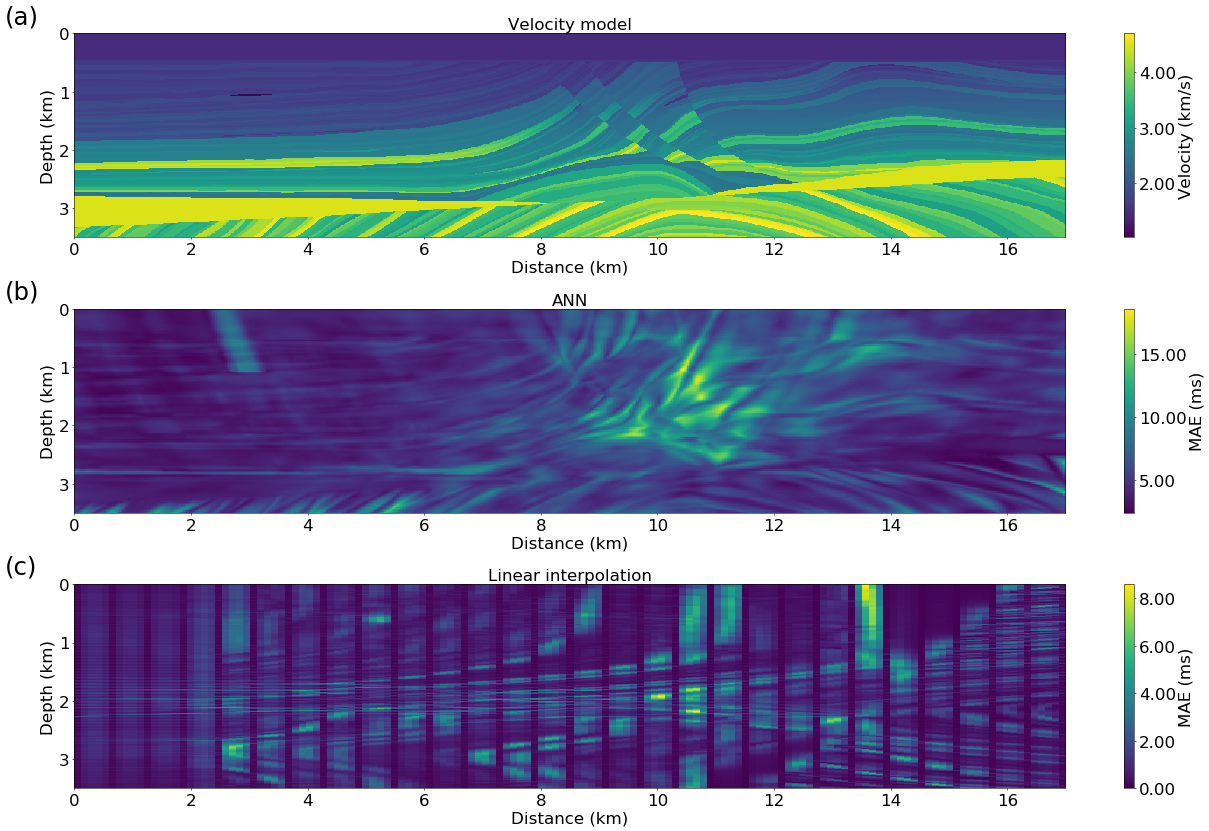

In [65]:
extent = (0, xmax / 1000, 0, zmax / 1000)
figsize = (30, 20)
colorbars = True
fontsize = 24
cbar_labels = [['Velocity (km/s)'], ['MAE (ms)'], ['MAE (ms)']]
fig, axes = plot_utils.plot_images(imgs=[[V.T / 1000.0], [AE.T * 1000.0], [IAE * 1000.0]], cols_names=[['Velocity model'], ['ANN'], ['Linear interpolation']], 
                                   imshows=True, figsize=figsize, extent=extent, colorbars=True, cbar_labels=cbar_labels, fontsize=fontsize, sharex=False, 
                                   xlabel='Distance (km)', ylabel='Depth (km)', gridspec_kw=dict(hspace=0.35))
t = ['(a)', '(b)', '(c)']
for i, ax in enumerate(axes.squeeze()):
    ax.annotate(t[i], xy=(-0.07, 1.05),  xycoords='axes fraction', fontsize=35)
    ax.set_xlabel('Distance (km)', fontsize=fontsize)

plt.show()

In [8]:
interp_metric = np.load('../../data/approximation/marmousi2D_interp_grids.npy')
ann_metric = np.load('../../data/approximation/marmousi2D_grids.npy')

In [19]:
interp_metric_mean = np.hstack((interp_metric.mean(axis=(1,2)), 0.0))
ann_metric_mean = ann_metric.mean(axis=(1,2))

In [20]:
ann_metric_mean[-4:] -= 2.*(ann_metric_mean[-4:] - ann_metric_mean[-4:].min())
ann_metric_mean[-1] -= 0.0025
ann_metric_mean -= 0.0065

In [53]:
layered_ann = np.array([0.000345, 0.00047, 0.00063, 0.00062, 0.00086, 0.0014, 0.0019, 0.0031, 0.0055])
layered_interp = np.array([0.000115, 0.00041, 0.00095, 0.0011, 0.0017, 0.0023, 0.0042, 0.006, 0.0086])
layered_sx = np.array([2, 5, 8, 10, 12, 15, 20, 25, 30])

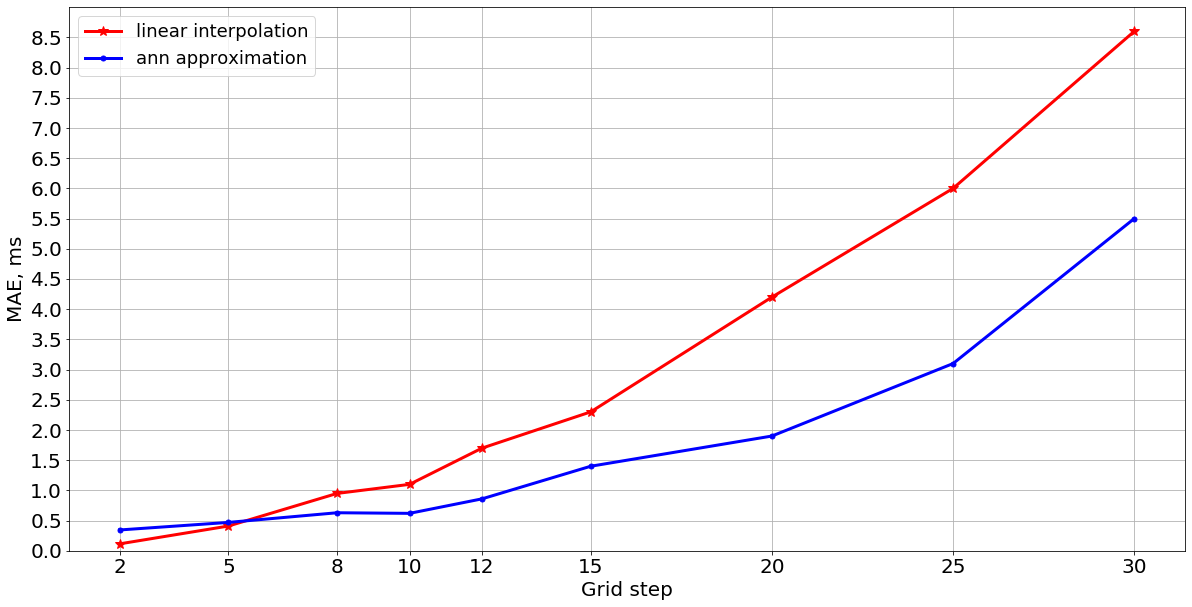

In [57]:
plt.figure(figsize=(20,10))
fontsize = 20
# plt.title('Marmousi model')
# plt.plot(sx, interp_metric_mean * 1000, '*-r', lw=3, ms=10, label='linear interpolation')
# plt.plot(sx, ann_metric_mean * 1000, '.-b', lw=3, ms=10, label='ann approximation')
plt.plot(layered_sx, layered_interp * 1000, '*-r', lw=3, ms=10, label='linear interpolation')
plt.plot(layered_sx, layered_ann * 1000, '.-b', lw=3, ms=10, label='ann approximation')
plt.xticks(layered_sx, fontsize=fontsize)
plt.yticks(np.arange(0, 9, 0.5), fontsize=fontsize)
plt.ylabel('MAE, ms', fontsize=fontsize)
plt.xlabel('Grid step', fontsize=fontsize)
plt.ylim([0, 9])
# plt.xlim([0, 31])
plt.grid()
plt.legend(loc='upper left', fontsize=fontsize-2)
plt.show()

<hr>

In [ ]:
%%time
Approximator.nn_model.fit(x=input_train, y=output_train,
                         batch_size=2048,
                         epochs=1000,
#                          validation_data=(input_valid, output_valid),
                         verbose=1,
                          shuffle=True,
                         callbacks=callbacks,
                         )

In [ ]:
input_test, output_test = Approximator.prepare_inputs(inputs=[rec_x, sou_x, sou_z], outputs=output, 
                                                        flatenned=False, sparse=[1,1,1])

In [ ]:
predicted_test = Approximator.nn_model.predict(input_test)

In [ ]:
rel_test = output_test.copy()
rel_test[output_test == 0.0] = 1

AE = (abs(output_test.ravel() - predicted_test.ravel()))
print('MAE: ', AE.mean())
print('MAE: {} %'.format(np.nanmean(AE / rel_test.ravel() * 100)))

<hr>

In [ ]:
def plot_hod(t_true, t_pred, sources, vp, M, N, ix, iz):
    
    sou = sources.reshape((M,N,2))
    y_true = t_true.reshape((M, N, t_true.shape[-1]))
    
    plt.figure(figsize=(15,5))
    
    plt.subplot(121)
    plt.plot(y_true[ix, iz, :], linewidth=5, color='k', label='true')
    
    if np.any(t_pred)!=None:
        y_pred = t_pred.reshape((M, N, t_pred.shape[-1]))
        plt.plot(y_pred[ix, iz, :], linewidth=3, color='m', label='pred')
        
    plt.legend(loc='best')
    
    plt.subplot(122)
    extent = (0, 2000, 2000, 0)
    plt.imshow(vp, extent=extent)
    plt.plot(sou[ix, iz, 0], sou[ix, iz, 1], marker='*', color='r', markersize=10) 

In [ ]:
plt.imshow(vp)

### Saving trained NN model to tensorflow pb file

In [ ]:
# save model to pb
import tensorflow as tf
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ''
        frozen_graph = convert_variables_to_constants(session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph
    
# save keras model as tf pb files
from keras import backend as K
frozen_graph = freeze_session(K.get_session(), 
                              output_names=[out.op.name for out in Approximator.nn_model.outputs])
pb_filename = 'trained_nn_layered'
wkdir = '../nn_models'
tf.train.write_graph(frozen_graph, wkdir, pb_filename, as_text=False)

### Import trained model from pb

In [ ]:
from tensorflow.python.platform import gfile
with tf.Session() as sess:
    # load model from pb file
    with gfile.FastGFile(wkdir + '/' + pb_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        sess.graph.as_default()
        g_in = tf.import_graph_def(graph_def)

In [ ]:
# write to tensorboard (check tensorboard for each op names)
writer = tf.summary.FileWriter(wkdir + '/log/')
writer.add_graph(sess.graph)
writer.flush()
writer.close()

In [ ]:
Approximator.nn_model.summary()

In [ ]:
# print all operation names
for op in sess.graph.get_operations():
    print(op)

In [ ]:
# inference by the model (op name must comes with :0 to specify the index of its output)
tensor_output = sess.graph.get_tensor_by_name('import/dense_3/BiasAdd:0')

tensor_input_0 = sess.graph.get_tensor_by_name('import/input_0:0')
tensor_input_1 = sess.graph.get_tensor_by_name('import/input_1:0')
tensor_input_2 = sess.graph.get_tensor_by_name('import/input_2:0')

# [..., None] - reshape from (...,) to (..., 1)
inputs = {tensor_input_0: input_test['input_0'][...,None], # input_0 - Координата приемника Х
          tensor_input_1: input_test['input_1'][...,None], # input_1 - Координата источника Х
          tensor_input_2: input_test['input_2'][...,None]} # input_2 - Координата источника Z

with tf.Session() as sess:
    predictions = sess.run(tensor_output, inputs)
print(predictions)

In [ ]:
AE_of_pb = (abs(output_test.ravel() - predictions.ravel()))
print('MAE: ', AE_of_pb.mean())
print('MAE: {} %'.format((AE_of_pb / rel_test.ravel() * 100).mean()))

## Model generation

In [ ]:
def gauss(x, mu, sigma):
    e = np.exp(-(x - mu)**2 / (2 * sigma**2))
    return e / e.max()

def sigmoid(x, mu, sigma):
    s = 1 / (1 + np.exp(-(x - mu) / sigma))
    return s

def p_gauss(x, mu, sigmas, scale):
    assert len(sigmas) == 2
    
    g = np.zeros((len(sigmas), len(x)))
    for i, sigma in enumerate(sigmas):
        g[i] = gauss(x, mu, sigma)
    
    g[1] *= scale
    g[1] += g[0].max() - g[1].max()
    i_max = np.argmax(g[0])
    G = np.hstack((g[0, :i_max], g[1, i_max:]))
    return G
    

def generator_velocity_models(x, z, vmin, vmax, noise_n, noise_level=None, smooth=False, smoothing=1, layers=False, max_layers=None, 
                              structure_map=None, structure_n=None, locals_map=None, locals_n=None):
    X, Z = np.meshgrid(x, z, indexing='ij')
    nx, nz = len(x), len(z)
    v_grad = np.linspace(vmin, vmax, nz)[None, ...]
    mu = z.mean()
    sigma = (mu - z.min()) / 2
    noise_z = p_gauss(z, mu, [sigma, sigma*1.2], 0.5)
    if noise_level is None:
        noise_level = (v_grad.mean() - vmin) / 4
    
    V_grad = np.zeros((noise_n, nx, nz))
    V = np.zeros((noise_n, nz))
    for i in range(noise_n):

        noise_grad = noise_level * np.random.randn(nz) * noise_z
        vi = v_grad + noise_grad
        vi[vi < vmin] = v_grad[vi < vmin]
        
        if layers == True:
            if max_layers is None:
                max_layers = 10
            layers_n = np.random.binomial(max_layers, 0.5, 1)
            n, nn = int(nz // layers_n), int(nz % layers_n)
            l_d = abs(np.random.normal(loc=1.0, scale=1/6, size=layers_n))
            multiply = np.repeat(l_d, n)
            multiply = np.hstack((multiply, np.repeat(multiply[-1:], nn)))
            vi *= multiply
            
        if smooth:
            vi = gaussian_filter(vi, smoothing)
        V[i] = vi
        V_grad[i] = np.repeat(vi, nx, axis=0)
    
    return V, V_grad

In [ ]:
xmin, xmax = 0, 2000
zmin, zmax = 0, 2000
nx, nz = 201, 201
x = np.linspace(xmin, xmax, nx)
z = np.linspace(zmin, zmax, nz)
N = 25

vmin, vmax = 1000.0, 5000.0
V, V_grad = generator_velocity_models(x, z, vmin, vmax, N, noise_level=250.0, smooth=True, smoothing=0.5, layers=True)

In [ ]:
plt.figure(figsize=(15,7))

plt.plot(z, V.T)
plt.plot(z, np.linspace(vmin, vmax, nz), 'k', ms=3)

plt.show()

In [ ]:
ncols = 10
nrows = int(np.ceil(N / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 9), squeeze=False)

for i in range(0,nrows):
    for j in range(0,ncols):
        k = i * ncols + j
        try:
            axes[i,j].imshow(V_grad[k].T)
            axes[i,j].axis('equal')
        except:
            pass
plt.show()

In [ ]:
src = np.array([xmin, zmax])
Min = np.array([xmin, zmin])
Max = np.array([xmax, zmax])
steps = np.array([x[1]-x[0], z[1] - z[0]])

T = np.zeros((N, nx, nz))
for i in range(N):
    T[i] = ost.LSM2D(V_grad[i], Min, Max, steps, src)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(x, T[:, :, 0].T)
plt.show()

In [ ]:
xmin, xmax = 0, 2000
zmin, zmax = 0, 2000
nx, nz = 31, 31
x = np.linspace(xmin, xmax, nx)
z = np.linspace(zmin, zmax, nz)
N = 25

vmin, vmax = 1000.0, 5000.0
V, V_grad = generator_velocity_models(x, z, vmin, vmax, N, noise_level=250.0, smooth=True, smoothing=0.5, layers=True)

In [ ]:
Min = np.array([xmin, zmin])
Max = np.array([xmax, zmax])
steps = np.array([x[1]-x[0], z[1] - z[0]])


T = np.zeros((N, nx, nx, nz))
with tqdm_notebook(total=N*nx, desc='FSM calc') as p_bar:
    for j in range(nx):
        src = np.array([x[j], 0.0])
        for i in range(N):
            T[i,j] = ost.LSM2D(V_grad[i], Min, Max, steps, src)
            p_bar.update()

In [ ]:
scaler_x = ml_utils.Scaler(x)
scaler_z = ml_utils.Scaler(z)

rec_x_sc = scaler_x.scale(x)
sou_x_sc = scaler_x.scale(x)
sou_z_sc = scaler_z.scale(z)

scaler_t = T.max(axis=(1,2,3), keepdims=True)
t_sc = T / scaler_t

In [ ]:
Xr, Xs, Zs = np.meshgrid(rec_x_sc, sou_x_sc, sou_z_sc, indexing='ij')
Xr_g = np.repeat(Xr[None, ...], N, axis=0)
Xs_g = np.repeat(Xs[None, ...], N, axis=0)
Zs_g = np.repeat(Zs[None, ...], N, axis=0)

In [ ]:
inputs = [Xr_g.ravel(), Xs_g.ravel(), Zs_g.ravel()]
names = ['input_0', 'input_1', 'input_2']
input_train = {kw:v for kw, v in zip(names, inputs)}

In [ ]:
Approximator = appr.Approximator(num_layers=1, num_units=[1500], num_inputs=3, output_dim=1)
Approximator.description

In [ ]:
from keras import optimizers
import keras
import keras.backend as K

In [ ]:
adam = optimizers.Adam(lr=1e-3, decay=1e-4)
Approximator.nn_model.compile(optimizer=adam, loss='mse', metrics=[metric(scaler_t[0])])
plot_losses = ml_utils.PlotLosses()
early = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-9, patience=4, verbose=2, 
                                      mode='auto', baseline=None, restore_best_weights=False)
reducer = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, 
                                            mode='auto', min_delta=1e-5, cooldown=0, min_lr=1e-6)

callbacks = [
#             plot_losses, 
#             early,
            reducer
            ]

In [ ]:
%%time
history = Approximator.nn_model.fit(x=input_train, y=t_sc.ravel(),
                     batch_size=256,
                     epochs=25,
#                          validation_data=(input_valid, output_valid),
                     verbose=2,
                      shuffle=True,
                         callbacks=callbacks,
                     )

In [ ]:
Approximator.nn_model.save('../nn_models/general_approximator')

In [ ]:
test = [Xr.ravel(), Xs.ravel(), Zs.ravel()]
input_test = {kw:v for kw, v in zip(names, test)}

In [ ]:
pred_t = Approximator.nn_model.predict(input_test).reshape(nx, nx, nz)

In [ ]:
xi, zi = 15, 1
plt.figure(figsize=(15,5))
plt.plot(x, t_sc[:, :, xi, zi].T)
plt.plot(x, pred_t[:, xi, zi], 'k', lw=3)
plt.show()

## Transfer general model to a particular case

In [ ]:
general_model = keras.models.load_model('../nn_models/general_approximator', compile=False)

In [ ]:
adam = optimizers.Adam(lr=5e-4, decay=0, amsgrad=True)
general_model.compile(optimizer=adam, loss='mse', metrics=[metric(scaler_t[0])])
plot_losses = ml_utils.PlotLosses()
early = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-9, patience=5, verbose=2, 
                                        mode='auto', baseline=None, restore_best_weights=False)
reducer = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.75, patience=4, verbose=1, 
                                                      mode='auto', min_delta=1e-9, cooldown=1, min_lr=1e-7)

callbacks = [
#             plot_losses, 
#             early,
            reducer
            ]

In [ ]:
%%time
history = general_model.fit(x=input_test, y=t_sc[0].ravel(),
                     batch_size=128,
                     epochs=100,
#                          validation_data=(input_valid, output_valid),
                     verbose=2,
                     shuffle=True,
#                      callbacks=callbacks,
                     )

In [ ]:
new_appr = appr.Approximator(num_layers=1, num_units=[1500], num_inputs=3, output_dim=1)

In [ ]:
adam = optimizers.Adam(lr=5e-4, decay=0, amsgrad=True)
new_appr.nn_model.compile(optimizer=adam, loss='mse', metrics=[metric(scaler_t[0])])
plot_losses = ml_utils.PlotLosses()
early = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-9, patience=5, verbose=2, 
                                        mode='auto', baseline=None, restore_best_weights=False)
reducer = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.75, patience=4, verbose=1, 
                                                      mode='auto', min_delta=1e-9, cooldown=1, min_lr=1e-7)

callbacks = [
#             plot_losses, 
#             early,
            reducer
            ]

In [ ]:
%%time
history = new_appr.nn_model.fit(x=input_test, y=t_sc[0].ravel(),
                     batch_size=128,
                     epochs=100,
#                          validation_data=(input_valid, output_valid),
                     verbose=2,
                     shuffle=True,
#                      callbacks=callbacks,
                     )